In [ ]:
# !wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=13BHpmkl44hZx0X1833q6UqdRw4S-Owx2' -O 'creditcard.csv'

In [1]:
# Package
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Other
from scipy.stats import norm
import random

# Model
import warnings
import xgboost as xgb
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.datasets import load_iris
from scipy.stats import randint
from scipy.stats import randint, uniform

In [2]:
# Install the Kaggle package
!pip install kaggle

# Import required libraries
import os
from google.colab import files

# Upload your Kaggle API token
uploaded = files.upload()

# Move the uploaded Kaggle API token to the appropriate location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using the Kaggle API
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzip the downloaded dataset
!unzip creditcardfraud.zip

# Now the dataset is available for use
# You can read the dataset into a pandas DataFrame or perform any other operations
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_csv("creditcard.csv")

# Display the first few rows of the DataFrame
print(df.head())

#Cancel file upload. then select yes to replace

#sensitive issue but lets see if we can build something. Extracted from pca and encryption. matrix comoressiom

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
100% 66.0M/66.0M [00:00<00:00, 119MB/s]
100% 66.0M/66.0M [00:00<00:00, 110MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.06

In [ ]:
print(df.tail())

            Time         V1         V2        V3        V4        V5  \
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.213454  0.111864   
284803  1.058415  0.024330  0.294869  0.584800  ...  0.214205  0.924384   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.232045  0.578229   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.265245  0.800049   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
284802  1.014480 -0.509348  1.436807  

# LOOKING AT DATA

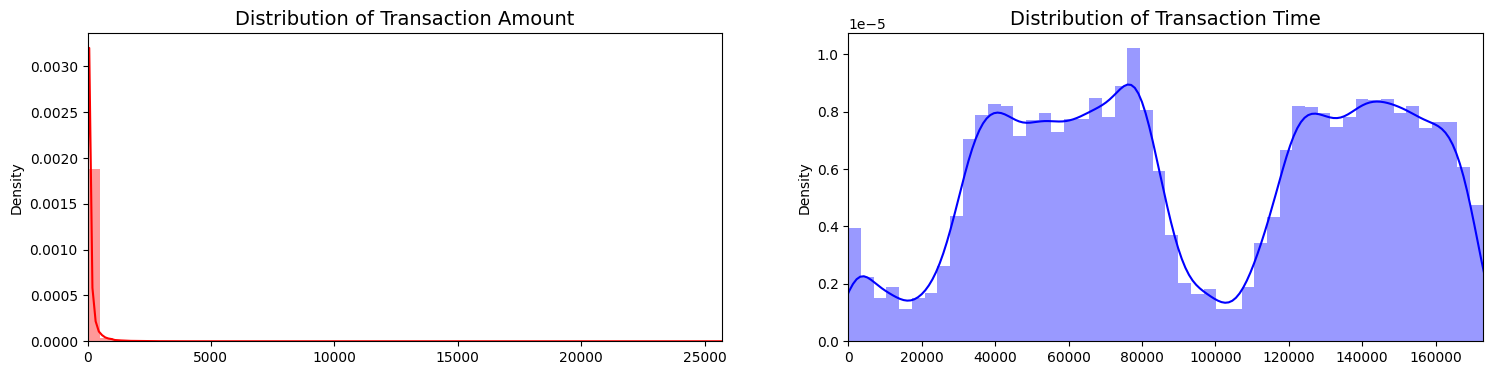

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [ ]:
print(df.shape)

# Making sure there isn't any null values
print(df.isnull().sum().max())

# Percentage

print("True")
real_cases = df[df['Class'] == 0]['Class'].value_counts()
print(real_cases)

print()

print("False")
false_cases = df[df['Class'] == 1]['Class'].value_counts()
print(false_cases)

realTransactions = df[df['Class'] == 0]['Class'].count()
fraudTransactions = df[df['Class'] == 1]['Class'].count()

ratioTransactions = (fraudTransactions / realTransactions) * 100

print()
print(f"{ratioTransactions:.2f}%")

(284807, 31)
0
True
Class
0    284315
Name: count, dtype: int64

False
Class
1    492
Name: count, dtype: int64

0.17%


# SHUFFLING DATASET

In [27]:
# Shuffling dataset
df = df.sample(frac = 1)

fraud_df = df.loc[df['Class'] == 1]
real_df = df.loc[df['Class'] == 0][:492]

normal_df = pd.concat([fraud_df, real_df])

new_df = normal_df.sample(frac = 1, random_state = 42)

# 492 Fraud and Real
print(new_df[new_df['Class'] == 0]['Class'].count())
print(new_df[new_df['Class'] == 1]['Class'].count())

492
492


In [28]:
print(new_df[new_df['Class'] == 0]['Class'].count())
print(new_df[new_df['Class'] == 1]['Class'].count())

492
492


# Graphics

In [ ]:
colors = ["#0101DF", "#DF0101"]

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud | 1: Fraud)')

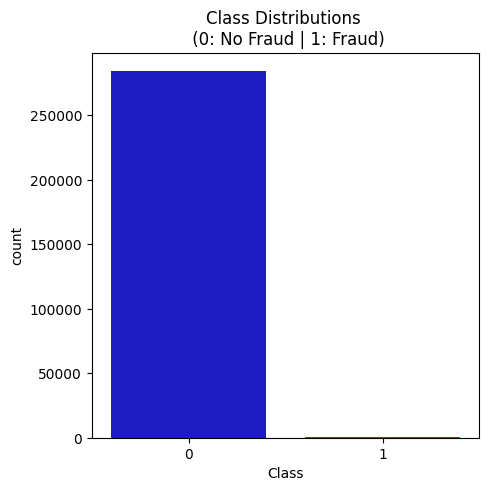

In [ ]:
# Distribution
fig, ax = plt.subplots(figsize = (5, 5))
colors = ["#0101DF", "#DF0101"]
sns.countplot(x = 'Class', data = df, palette = colors,)
plt.title('Class Distributions \n (0: No Fraud | 1: Fraud)')


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud | 1: Fraud)')

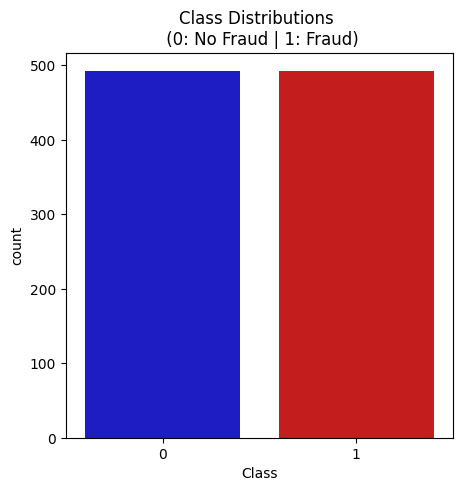

In [ ]:
# Distribution
fig, ax = plt.subplots(figsize = (5, 5))
colors = ["#0101DF", "#DF0101"]
sns.countplot(x = 'Class', data = new_df, palette = colors,)
plt.title('Class Distributions \n (0: No Fraud | 1: Fraud)')


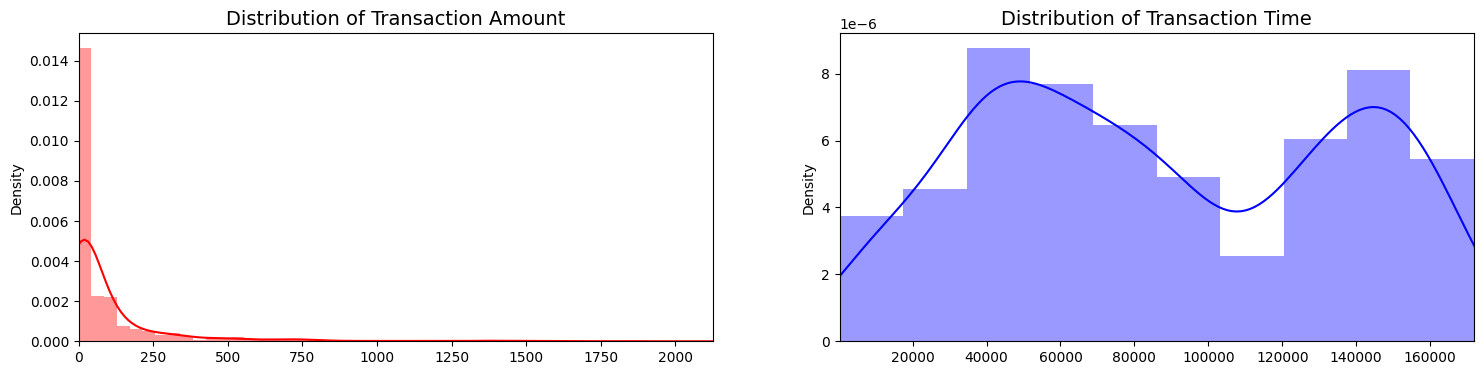

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = new_df['Amount'].values
time_val = new_df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

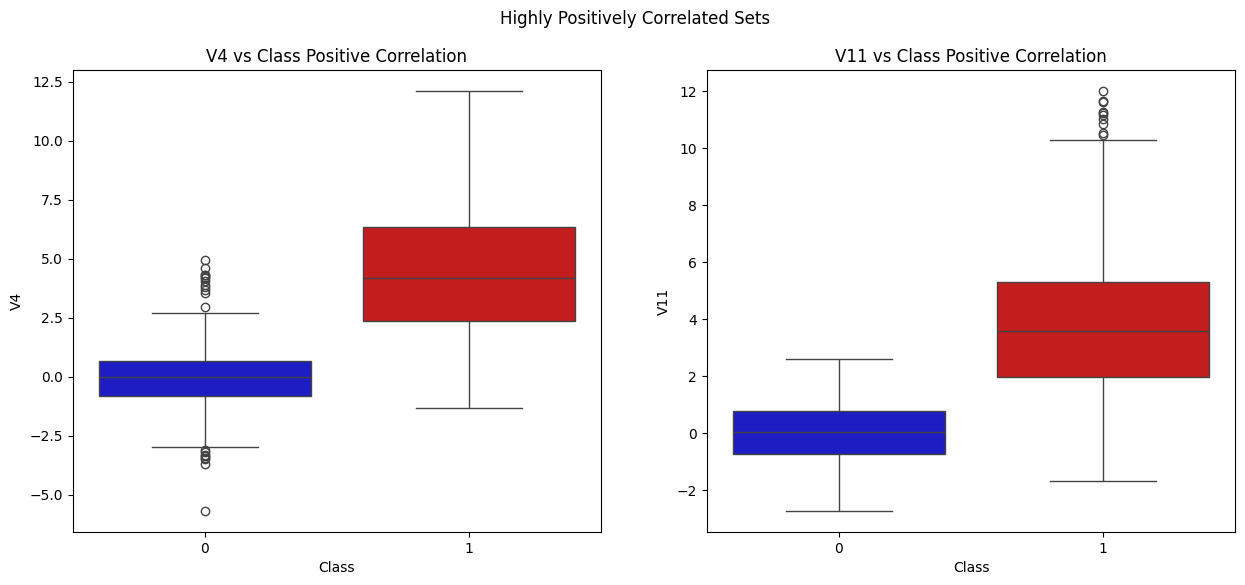

In [ ]:
# Highly Positively Correlated Sets: (V4, Class): 0.71, (V11, Class): 0.69
# Highly Negatively Correlated Sets: (V10, Class): -0.63, (V12, Class): -0.69, (V14, Class): -0.75

# Create a figure and axes for positively correlated sets
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Highly Positively Correlated Sets')

# Box plot for V4 vs Class
sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

# Box plot for V11 vs Class
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')

plt.show()

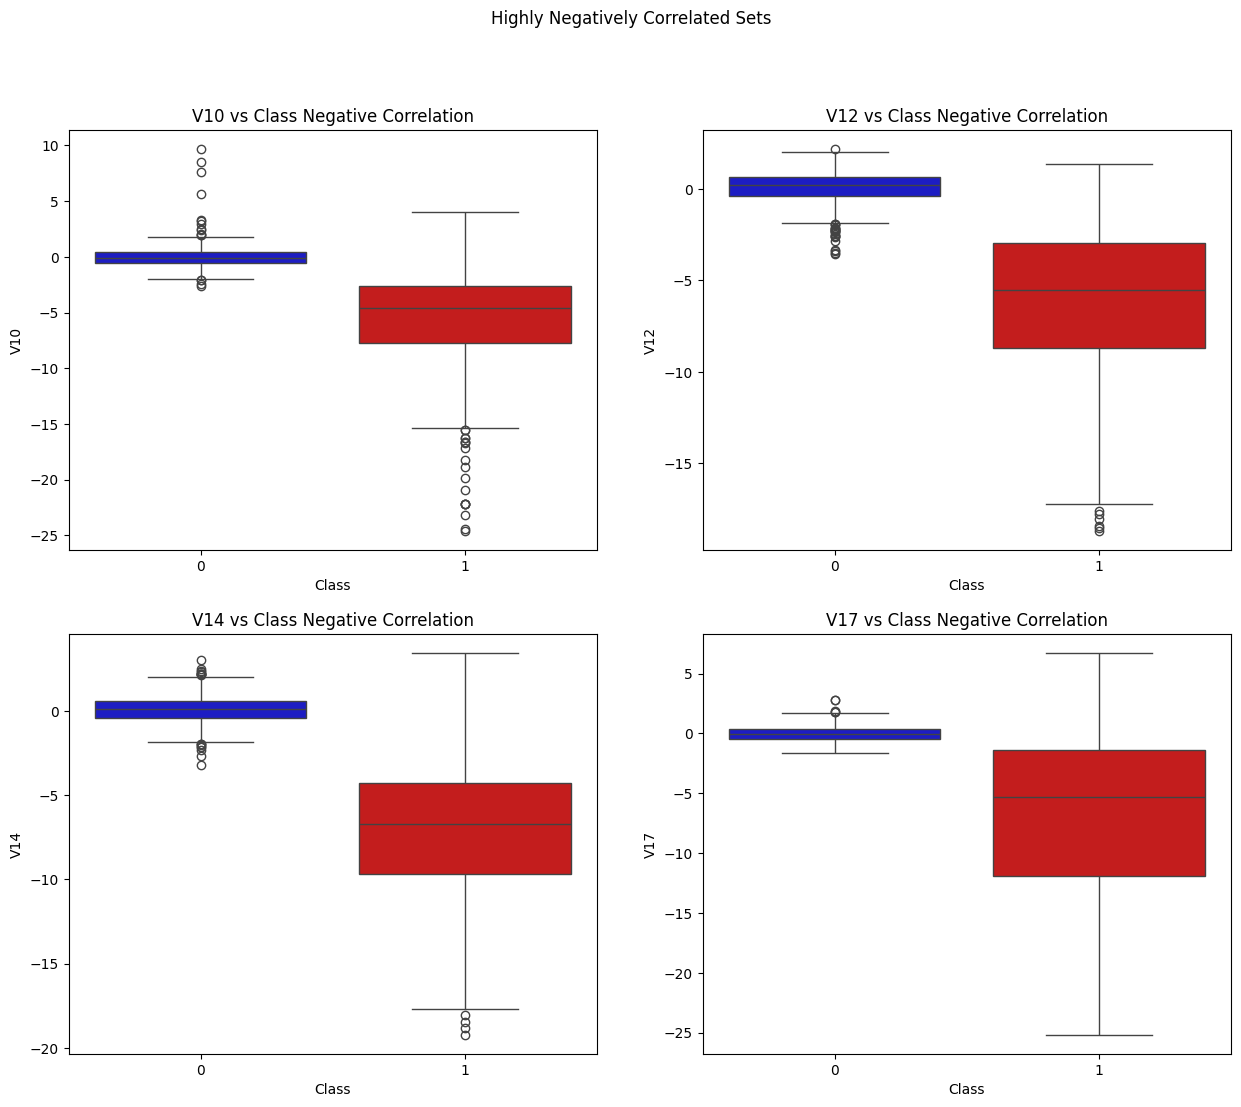

In [ ]:
# Create a figure and axes for negatively correlated sets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Highly Negatively Correlated Sets')

# Box plot for V10 vs Class
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0, 0])
axes[0, 0].set_title('V10 vs Class Negative Correlation')

# Box plot for V12 vs Class
sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[0, 1])
axes[0, 1].set_title('V12 vs Class Negative Correlation')

# Box plot for V14 vs Class
sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1, 0])
axes[1, 0].set_title('V14 vs Class Negative Correlation')

# Box plot for V17 vs Class (if you want to include it, otherwise ignore this part)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[1, 1])
axes[1, 1].set_title('V17 vs Class Negative Correlation')

plt.show()

# REMOVAL

15
V14    0
V12    0
V10    0
V4     0
V11    0
dtype: int64
Iteration Number: 0
Number of Outliers in V14: 2
Number of Outliers in V12: 10
Number of Outliers in V10: 25
Number of Outliers in V4: 8
Number of Outliers in V11: 7
Total Data Removed from Dataset: 52


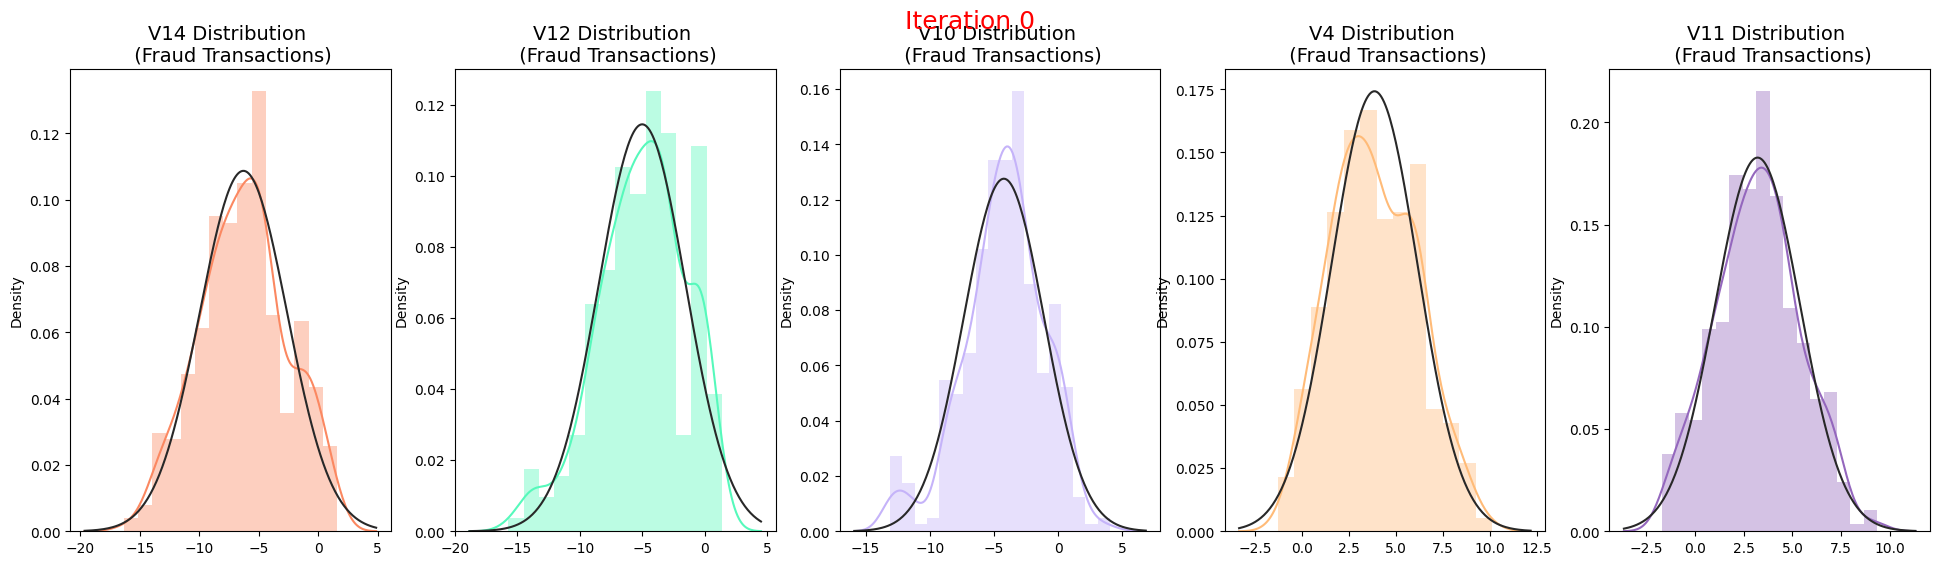

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have already loaded and processed your DataFrame `new_df`
total_outliers_removed = 0

# Extract relevant columns for fraudulent transactions
fraudulent_transactions = new_df[new_df['Class'] == 1]

# Print the count of duplicated and missing values
print(fraudulent_transactions[['V14', 'V12', 'V10', 'V4', 'V11']].duplicated().sum())
print(fraudulent_transactions[['V14', 'V12', 'V10', 'V4', 'V11']].isnull().sum())

# Drop rows with missing values in the specified columns
cleaned_fraudulent_transactions = fraudulent_transactions[['V14', 'V12', 'V10', 'V4', 'V11']].dropna()

# Extract values for the cleaned variables
v14_fraud_dist = cleaned_fraudulent_transactions['V14'].values
v12_fraud_dist = cleaned_fraudulent_transactions['V12'].values
v10_fraud_dist = cleaned_fraudulent_transactions['V10'].values
v4_fraud_dist = cleaned_fraudulent_transactions['V4'].values
v11_fraud_dist = cleaned_fraudulent_transactions['V11'].values

count = 0
outliers_found = True

# Repeat until no outliers are found for all variables
while count < 1 and outliers_found:
    outliers_found = False  # Assume no outliers found initially

    # Calculate descriptive statistics for each variable
    def calc_stats(values):
        return {
            "mean": np.mean(values),
            "median": np.median(values),
            "std_dev": np.std(values),
            "Q1": np.percentile(values, 25),
            "Q3": np.percentile(values, 75),
            "IQR": np.percentile(values, 75) - np.percentile(values, 25)
        }

    stats = {
        "V14": calc_stats(v14_fraud_dist),
        "V12": calc_stats(v12_fraud_dist),
        "V10": calc_stats(v10_fraud_dist),
        "V4": calc_stats(v4_fraud_dist),
        "V11": calc_stats(v11_fraud_dist)
    }

    # Identify outliers based on IQR for each variable
    def find_outliers(values, Q1, Q3, IQR):
        return (values < Q1 - 1.5 * IQR) | (values > Q3 + 1.5 * IQR)

    v14_outliers = find_outliers(v14_fraud_dist, stats["V14"]["Q1"], stats["V14"]["Q3"], stats["V14"]["IQR"])
    v12_outliers = find_outliers(v12_fraud_dist, stats["V12"]["Q1"], stats["V12"]["Q3"], stats["V12"]["IQR"])
    v10_outliers = find_outliers(v10_fraud_dist, stats["V10"]["Q1"], stats["V10"]["Q3"], stats["V10"]["IQR"])
    v4_outliers = find_outliers(v4_fraud_dist, stats["V4"]["Q1"], stats["V4"]["Q3"], stats["V4"]["IQR"])
    v11_outliers = find_outliers(v11_fraud_dist, stats["V11"]["Q1"], stats["V11"]["Q3"], stats["V11"]["IQR"])

    # Check if outliers were found
    if any([np.any(v14_outliers), np.any(v12_outliers), np.any(v10_outliers), np.any(v4_outliers), np.any(v11_outliers)]):
        outliers_found = True

        # Print outliers
        print("Iteration Number:", count)
        v14_outlier_count = len(v14_fraud_dist[v14_outliers])
        v12_outlier_count = len(v12_fraud_dist[v12_outliers])
        v10_outlier_count = len(v10_fraud_dist[v10_outliers])
        v4_outlier_count = len(v4_fraud_dist[v4_outliers])
        v11_outlier_count = len(v11_fraud_dist[v11_outliers])

        print("Number of Outliers in V14:", v14_outlier_count)
        print("Number of Outliers in V12:", v12_outlier_count)
        print("Number of Outliers in V10:", v10_outlier_count)
        print("Number of Outliers in V4:", v4_outlier_count)
        print("Number of Outliers in V11:", v11_outlier_count)

        # Total outliers in this iteration
        iteration_outliers = v14_outlier_count + v12_outlier_count + v10_outlier_count + v4_outlier_count + v11_outlier_count
        total_outliers_removed += iteration_outliers

        print('Total Data Removed from Dataset:', total_outliers_removed)


        # Drop outliers from each variable
        new_df = new_df.drop(new_df[new_df['V14'].isin(v14_fraud_dist[v14_outliers])].index)
        new_df = new_df.drop(new_df[new_df['V12'].isin(v12_fraud_dist[v12_outliers])].index)
        new_df = new_df.drop(new_df[new_df['V10'].isin(v10_fraud_dist[v10_outliers])].index)
        new_df = new_df.drop(new_df[new_df['V4'].isin(v4_fraud_dist[v4_outliers])].index)
        new_df = new_df.drop(new_df[new_df['V11'].isin(v11_fraud_dist[v11_outliers])].index)

        # Update data for next iteration
        v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
        v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
        v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
        v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
        v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values

        # Create a new subplot for this iteration
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 6))
        plt.suptitle(f'Iteration {count}', fontsize=18, color='red')

        # Plot distribution for V14
        sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
        ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

        # Plot distribution for V12
        sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
        ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

        # Plot distribution for V10
        sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
        ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

        # Plot distribution for V4
        sns.distplot(v4_fraud_dist, ax=ax4, fit=norm, color='#FFBB78')
        ax4.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

        # Plot distribution for V11
        sns.distplot(v11_fraud_dist, ax=ax5, fit=norm, color='#9467BD')
        ax5.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

        plt.show()  # Show the current iteration's plots

        count += 1

In [ ]:
print(new_df[new_df['Class'] == 0]['Class'].count())
print(new_df[new_df['Class'] == 1]['Class'].count())

# Fraud - No Fraud Refactoring
clean = new_df[new_df['Class'] == 0]['Class'].count()
unclean = new_df[new_df['Class'] == 1]['Class'].count()

421
421


In [ ]:
fraud_df = new_df.loc[new_df['Class'] == 1]
real_df = new_df.loc[new_df['Class'] == 0][:unclean]

# Assuming `unclean` is the variable determining the size of `real_df`
print(fraud_df['Class'].count())  # Should output 465
print(real_df['Class'].count())   # Should output 465

# If the total count is odd, remove one sample from each DataFrame
if ((fraud_df.shape[0] + real_df.shape[0])* 0.8) % 2 != 0:
    fraud_df = fraud_df.iloc[:-1]
    real_df = real_df.iloc[:-1]

new_df = pd.concat([fraud_df, real_df])

# Shuffle the new_df
new_df = new_df.sample(frac=1, random_state=42)

# Print the final counts to verify
print("Final fraud count:", fraud_df['Class'].count())
print("Final real count:", real_df['Class'].count())
print("Total count:", new_df['Class'].count())

421
421
Final fraud count: 420
Final real count: 420
Total count: 840


RENDITION 1

# New Graphs

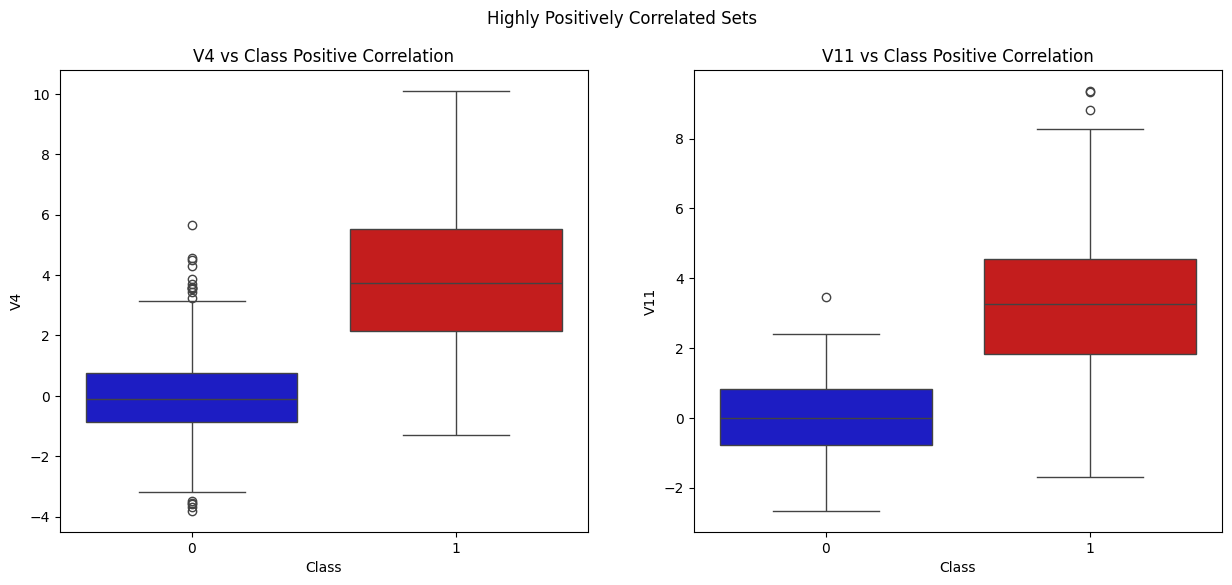

In [ ]:
# Highly Positively Correlated Sets: (V4, Class): 0.71, (V11, Class): 0.69
# Highly Negatively Correlated Sets: (V10, Class): -0.63, (V12, Class): -0.69, (V14, Class): -0.75

# Create a figure and axes for positively correlated sets
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Highly Positively Correlated Sets')

# Box plot for V4 vs Class
sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

# Box plot for V11 vs Class
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')

plt.show()

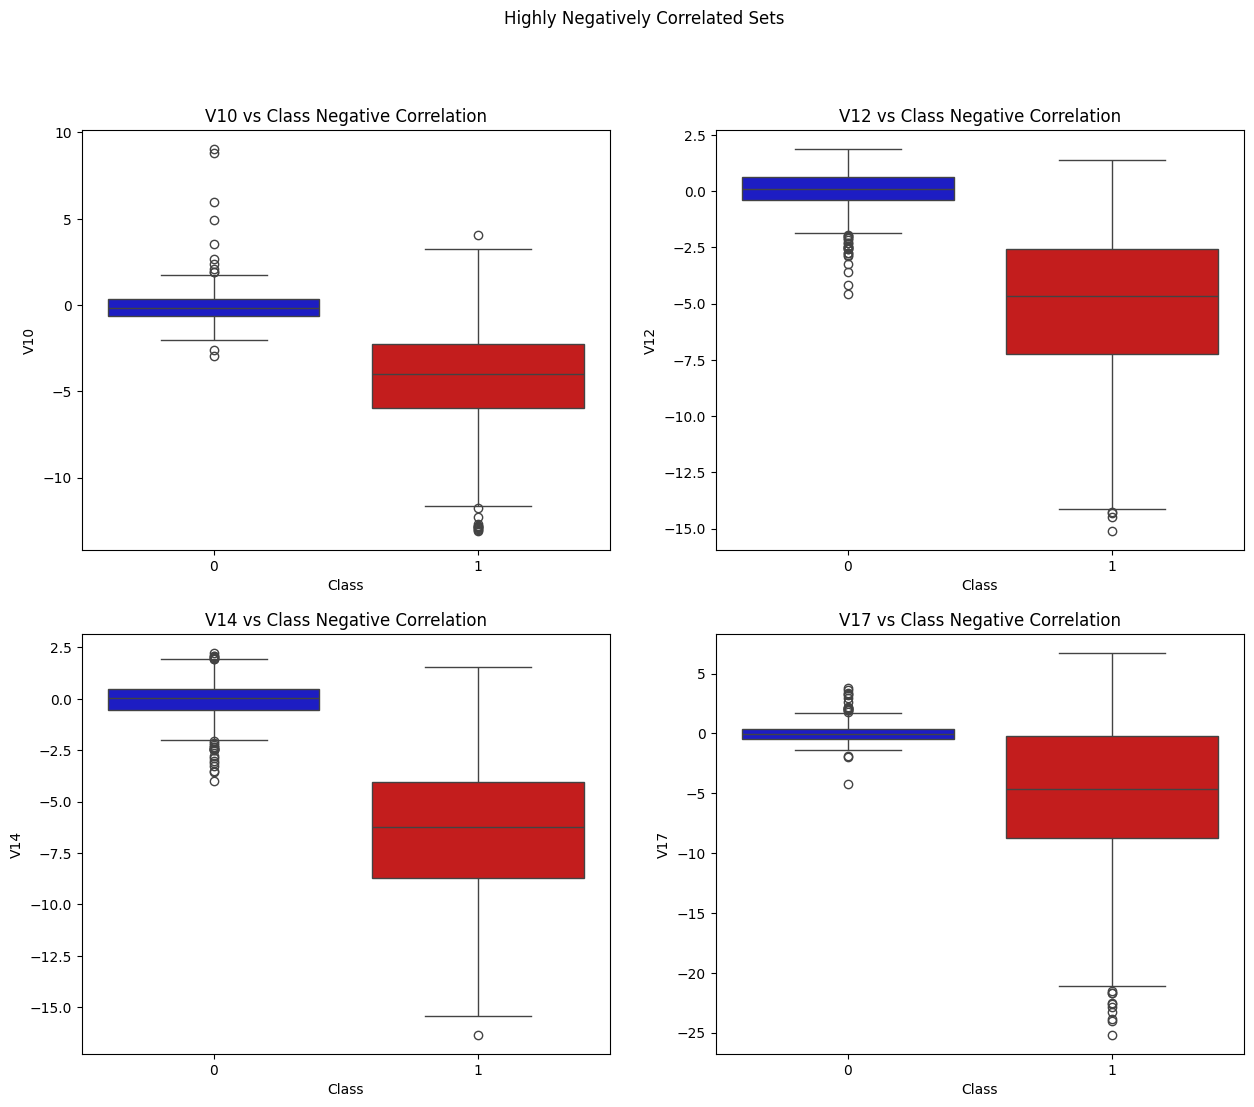

In [ ]:
# Create a figure and axes for negatively correlated sets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Highly Negatively Correlated Sets')

# Box plot for V10 vs Class
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0, 0])
axes[0, 0].set_title('V10 vs Class Negative Correlation')

# Box plot for V12 vs Class
sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[0, 1])
axes[0, 1].set_title('V12 vs Class Negative Correlation')

# Box plot for V14 vs Class
sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1, 0])
axes[1, 0].set_title('V14 vs Class Negative Correlation')

# Box plot for V17 vs Class (if you want to include it, otherwise ignore this part)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[1, 1])
axes[1, 1].set_title('V17 vs Class Negative Correlation')

plt.show()

# TRAINING SPLIT

In [29]:
# Define features (X) and labels (y)
X = new_df.drop(columns='Class')
y = new_df['Class']

# Split the data into training + temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the counts to confirm
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

print("Training labels size:", len(y_train))
print("Validation labels size:", len(y_val))
print("Test labels size:", len(y_test))

combined_x = pd.concat([X_train, X_val])
combined_y = pd.concat([y_train, y_val])

Training set size: 787
Validation set size: 98
Test set size: 99
Training labels size: 787
Validation labels size: 98
Test labels size: 99


# XGBoost

In [ ]:
import xgboost as xgb

# Define the parameter grid
param_grid = {
   'n_estimators': [10, 50, 100, 200],  # Number of boosting rounds
   'max_depth': [1, 2, 3, 5],        # Maximum depth of each tree
}

# Define the parameters for the model
gs_xgb = GridSearchCV(
   xgb.XGBRegressor(random_state=42),  # XGBoost regressor with fixed random state
   return_train_score=True,            # Return training scores
   param_grid=param_grid,              # Parameter grid for grid search
   cv=5,                               # Number of cross-validation folds
   scoring='roc_auc'                        # Use R^2 as the scoring metric
)

# Fit the model using grid search
gs_xgb.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters: ", gs_xgb.best_params_)

Best parameters:  {'max_depth': 1, 'n_estimators': 100}


In [ ]:
best_xgb = XGBClassifier(n_estimators = 25, max_depth = 1, random_state = 42)

best_xgb.fit(combined_x, combined_y)

# Step 4: Evaluate on the test set
test_pred_xg = best_xgb.predict(X_test)
test_proba_xg = best_xgb.predict_proba(X_test)[:, 1]

# Step 5: Calculate metrics for the test set
accuracy_test = accuracy_score(y_val, test_pred_xg)
auc_test = roc_auc_score(y_val, test_proba_xg)
recall_test = recall_score(y_val, test_pred_xg)
precision_test = precision_score(y_val, test_pred_xg)
f1_test = f1_score(y_val, test_pred_xg)

# Assuming gs_xgb is your GridSearchCV object
best_params = gs_xgb.best_params_

# Extract specific parameters from the best_params_ dictionary
max_depth = best_params.get('max_depth')
n_estimators = best_params.get('n_estimators')

print("Max Depth:", max_depth)
print("Number of Estimators:", n_estimators)

# Step 6: Print test set evaluation metrics
print("Test Set Evaluation Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"AUC: {auc_test}")
print(f"Recall: {recall_test}")
print(f"Precision: {precision_test}")
print(f"F1 Score: {f1_test}")

Max Depth: 1
Number of Estimators: 100
Test Set Evaluation Metrics:
Accuracy: 0.4880952380952381
AUC: 0.45337528604118993
Recall: 0.5217391304347826
Precision: 0.5333333333333333
F1 Score: 0.5274725274725275


# Logistic Regression

In [16]:
df_train = X_train.copy()
df_train['Class'] = y_train

combined_data = combined_x.copy()
combined_data['Class'] = combined_y

df_test =  X_test.copy()
df_test['Class'] = y_test

First run

In [17]:
# Create a formula string for logistic regression
# "Class ~ ." means 'Class' as a function of all other columns in the DataFrame
# formula_1 = 'Class ~ ' + ' + '.join(X_train.columns)
# Generate the formula dynamically
variables = ' + '.join([f'V{i}' for i in range(1, 29)])
formula_1 = f'Class ~ {variables} + Time + Amount'


# Build the logistic regression model
model_1 = smf.logit(formula=formula_1, data=df_train)
res_1 = model_1.fit()

# Print the summary of the model to see the results
print(res_1.summary())



         Current function value: 0.124270
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  787
Model:                          Logit   Df Residuals:                      756
Method:                           MLE   Df Model:                           30
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.8206
Time:                        03:26:19   Log-Likelihood:                -97.801
converged:                      False   LL-Null:                       -545.17
Covariance Type:            nonrobust   LLR p-value:                7.805e-169
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -59.4289   1943.948     -0.031      0.976   -3869.498    3750.640
V1             7.6292    422.069      0.018      0.986    -819.61

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions on training set
train_predictions = res_1.predict(df_train)
train_predictions = [1 if x > 0.5 else 0 for x in train_predictions]

# Predictions on test set
test_predictions = res_1.predict(df_test)
test_predictions = [1 if x > 0.5 else 0 for x in test_predictions]

# True labels for training set
y_train_true = df_train['Class']

# True labels for test set
y_test_true = df_test['Class']

# Evaluation metrics for training set
train_accuracy = accuracy_score(y_train_true, train_predictions)
train_precision = precision_score(y_train_true, train_predictions)
train_recall = recall_score(y_train_true, train_predictions)
train_f1 = f1_score(y_train_true, train_predictions)
train_auc = roc_auc_score(y_train_true, train_predictions)

# Evaluation metrics for test set
test_accuracy = accuracy_score(y_test_true, test_predictions)
test_precision = precision_score(y_test_true, test_predictions)
test_recall = recall_score(y_test_true, test_predictions)
test_f1 = f1_score(y_test_true, test_predictions)
test_auc = roc_auc_score(y_test_true, test_predictions)

# Print evaluation metrics for training set
print("Training Set Metrics:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1-score:", train_f1)
print("AUC:", train_auc)

# Print evaluation metrics for test set
print("\nTest Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1-score:", test_f1)
print("AUC:", test_auc)

Training Set Metrics:
Accuracy: 0.9466327827191868
Precision: 0.9722222222222222
Recall: 0.9162303664921466
F1-score: 0.9433962264150944
AUC: 0.9457695042337276

Test Set Metrics:
Accuracy: 0.9595959595959596
Precision: 0.9814814814814815
Recall: 0.9464285714285714
F1-score: 0.9636363636363636
AUC: 0.9615863787375415


Optimal

In [19]:
import statsmodels.api as sm

def backward_elimination(X_train, y_train, significance_level=0.05):
    # Add a constant term to the independent variables
    X_train_with_constant = sm.add_constant(X_train)
    highest_pvalues = []
    remaining_variables = set(X_train_with_constant.columns)

    while True:
        # Create the Logit model
        model = sm.Logit(y_train, X_train_with_constant)

        # Fit the model
        results = model.fit()

        # Find the variable with the highest p-value
        max_pvalue = results.pvalues.max()
        max_pvalue_variable = results.pvalues.idxmax()

        if max_pvalue > significance_level:
            # Remove the variable with the highest p-value
            highest_pvalues.append((max_pvalue_variable, max_pvalue))
            max_pvalue_index = results.pvalues.idxmax()
            X_train_with_constant = X_train_with_constant.drop(max_pvalue_index, axis=1)
            remaining_variables.remove(max_pvalue_variable)
        else:
            break

    remaining_variables_list = list(remaining_variables)

    return results, model, highest_pvalues, remaining_variables

# Assume X_train and y_train are already defined and contain your data

# Perform backward elimination
res_final, logit, highest_pvalues, remaining_variables_list = backward_elimination(X_train, y_train)

# Remove 'const' if it's in the list
if 'const' in remaining_variables_list:
  remaining_variables_list.remove('const')

# Print the variables with the highest p-values removed during the process
print("Removed variables:")
for variable, pvalue in highest_pvalues:
    print(f'{variable}: p-value = {pvalue}')

# Print the remaining variables in the final model
print("\nRemaining variables:")
for variable in remaining_variables_list:
    print(variable)

# # Print the summary of the final model
# print(res_final.summary())



         Current function value: 0.124270
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.124435
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.125071
         Iterations 24
Removed variables:
V1: p-value = 0.9855783597566755
Time: p-value = 0.32151990301775557

Remaining variables:
V5
V11
V9
V6
V22
V7
V3
V12
V23
V20
V24
V27
V14
V2
V10
V18
V25
V16
V4
V21
V28
Amount
V13
V17
V26
V19
V8
V15


Final

In [20]:
# Convert the remaining variables to a formula string
remaining_varaibles_str = None
remaining_variables_str = ' + '.join(remaining_variables_list)
# Assuming 'Class' is the dependent variable
formula_2 = f'Class ~ {remaining_variables_str}'

# Print the dynamically created formula
print("\nDynamically created formula:")
print(formula_2)

# Build the logistic regression model using the dynamically created formula
model_2 = smf.logit(formula=formula_2, data=df_train)
res_2 = model_2.fit()

# Print the summary of the model to see the results
print("\nNew logistic regression model summary with remaining variables:")
print(res_2.summary())


Dynamically created formula:
Class ~ V5 + V11 + V9 + V6 + V22 + V7 + V3 + V12 + V23 + V20 + V24 + V27 + V14 + V2 + V10 + V18 + V25 + V16 + V4 + V21 + V28 + Amount + V13 + V17 + V26 + V19 + V8 + V15
Optimization terminated successfully.
         Current function value: 0.125071
         Iterations 24

New logistic regression model summary with remaining variables:
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  787
Model:                          Logit   Df Residuals:                      758
Method:                           MLE   Df Model:                           28
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.8194
Time:                        03:26:20   Log-Likelihood:                -98.431
converged:                       True   LL-Null:                       -545.17
Covariance Type:            nonrobust   LLR p-value:                4.494e-170
 

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions on training set
train_predictions = res_2.predict(df_train)
train_predictions = [1 if x > 0.5 else 0 for x in train_predictions]

# Predictions on test set
test_predictions = res_2.predict(df_test)
test_predictions = [1 if x > 0.5 else 0 for x in test_predictions]

# True labels for training set
y_train_true = df_train['Class']

# True labels for test set
y_test_true = df_test['Class']

# Evaluation metrics for training set
train_accuracy = accuracy_score(y_train_true, train_predictions)
train_precision = precision_score(y_train_true, train_predictions)
train_recall = recall_score(y_train_true, train_predictions)
train_f1 = f1_score(y_train_true, train_predictions)
train_auc = roc_auc_score(y_train_true, train_predictions)

# Evaluation metrics for test set
test_accuracy = accuracy_score(y_test_true, test_predictions)
test_precision = precision_score(y_test_true, test_predictions)
test_recall = recall_score(y_test_true, test_predictions)
test_f1 = f1_score(y_test_true, test_predictions)
test_auc = roc_auc_score(y_test_true, test_predictions)

# Print evaluation metrics for training set
print("Training Set Metrics:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1-score:", train_f1)
print("AUC:", train_auc)

# Print evaluation metrics for test set
print("\nTest Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1-score:", test_f1)
print("AUC:", test_auc)

Training Set Metrics:
Accuracy: 0.9479034307496823
Precision: 0.9722991689750693
Recall: 0.918848167539267
F1-score: 0.9448183041722745
AUC: 0.9470784047572879

Test Set Metrics:
Accuracy: 0.9494949494949495
Precision: 0.9811320754716981
Recall: 0.9285714285714286
F1-score: 0.9541284403669724
AUC: 0.9526578073089701


# Decision Trees

In [ ]:
results = []

for min_samples in [1,10,25,50]: #THINK ABOUT WHAT MIN_SAMPLE NUMBERS TO USE
  for depth in [3,4,5,6,7]:     #SAME THING HERE
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples, max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    val_pred = dt.predict(X_val)
    val_proba = dt.predict_proba(X_val)[:, 1]

    accuracy = accuracy_score(y_val, val_pred)
    auc = roc_auc_score(y_val, val_proba)
    recall = recall_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)

    results.append((min_samples, depth, accuracy, auc, recall, precision, f1))

results_df = pd.DataFrame(results, columns=['min_samples_leaf', 'max_depth', 'Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score'])

results_df

best_model = results_df.loc[results_df['AUC'].idxmax()]
print("First model configuration:")
print(best_model)

param_grid = {
   'min_samples_leaf': [1,10,25],
   'max_depth': [3,4,5,6],
}

gs_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    return_train_score=True,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5
)

gs_tree.fit(combined_x, combined_y)
gs_tree.cv_results_
print("Best parameters: ", gs_tree.best_params_)

First model configuration:
min_samples_leaf    25.000000
max_depth            4.000000
Accuracy             0.916667
AUC                  0.975400
Recall               0.869565
Precision            0.975610
F1 Score             0.919540
Name: 11, dtype: float64
Best parameters:  {'max_depth': 4, 'min_samples_leaf': 25}


In [ ]:
best_params = gs_tree.best_params_
depth = best_params['max_depth']
leaves = best_params['min_samples_leaf']

print("Max Depth:", depth)
print("Min Samples Leaf:", leaves)

dt = DecisionTreeClassifier(min_samples_leaf = leaves, max_depth = depth, random_state=42)
dt.fit(X_test, y_test)
val_pred = dt.predict(X_val)
val_proba = dt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, val_pred)
auc = roc_auc_score(y_val, val_proba)
recall = recall_score(y_val, val_pred)
precision = precision_score(y_val, val_pred)
f1 = f1_score(y_val, val_pred)

results.append((min_samples, depth, accuracy, auc, recall, precision, f1))

results_df = pd.DataFrame(results, columns=['min_samples_leaf', 'max_depth', 'Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score'])

results_df

best_model = results_df.loc[results_df['AUC'].idxmax()]
print("Best model configuration:")
print(best_model)

Max Depth: 4
Min Samples Leaf: 25
Best model configuration:
min_samples_leaf    25.000000
max_depth            4.000000
Accuracy             0.916667
AUC                  0.975400
Recall               0.869565
Precision            0.975610
F1 Score             0.919540
Name: 11, dtype: float64


# Random Forest

In [30]:
results_rf = []

for estimators in [50,80,100]:
    for depth in [3,4,5,6]:
        rf = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)
        val_pred_rf = rf.predict(X_val)
        val_proba_rf = rf.predict_proba(X_val)[:, 1]

        accuracy_rf = accuracy_score(y_val, val_pred_rf)
        auc_rf = roc_auc_score(y_val, val_proba_rf)
        recall_rf = recall_score(y_val, val_pred_rf)
        precision_rf = precision_score(y_val, val_pred_rf)
        f1_rf = f1_score(y_val, val_pred_rf)

        results_rf.append((estimators, depth, accuracy_rf, auc_rf, recall_rf, precision_rf, f1_rf))

results_rf_df = pd.DataFrame(results_rf, columns=['Estimators', 'Depth', 'Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score'])
results_rf_df

best_model = results_rf_df.loc[results_rf_df['AUC'].idxmax()]

print("Best model configuration:")
print(best_model)

combined_x = pd.concat([X_train, X_val])
combined_y = pd.concat([y_train, y_val])

param_grid = {
   'n_estimators': [50,80,100] ,
   'max_depth': [3,4,5,6],
}

gs_forest = GridSearchCV(
    RandomForestClassifier(random_state=42),
    return_train_score=True,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5
)
gs_forest.fit(combined_x, combined_y)

gs_forest.cv_results_

print("Best parameters: ", gs_forest.best_params_)

Best model configuration:
Estimators    50.000000
Depth          4.000000
Accuracy       0.928571
AUC            0.978956
Recall         0.925926
Precision      0.943396
F1 Score       0.934579
Name: 1, dtype: float64
Best parameters:  {'max_depth': 6, 'n_estimators': 100}


In [24]:
# Assuming gs_forest is your GridSearchCV object
best_params = gs_forest.best_params_
max_depth = best_params['max_depth']
n_estimators = best_params['n_estimators']

print("Max Depth:", max_depth)
print("Number of Estimators:", n_estimators)

rf = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=42)
rf.fit(X_test, y_test)
val_pred_rf = rf.predict(X_val)
val_proba_rf = rf.predict_proba(X_val)[:, 1]

accuracy_rf = accuracy_score(y_val, val_pred_rf)
auc_rf = roc_auc_score(y_val, val_proba_rf)
recall_rf = recall_score(y_val, val_pred_rf)
precision_rf = precision_score(y_val, val_pred_rf)
f1_rf = f1_score(y_val, val_pred_rf)

results_rf.append((estimators, depth, accuracy_rf, auc_rf, recall_rf, precision_rf, f1_rf))

results_rf_df = pd.DataFrame(results_rf, columns=['Estimators', 'Depth', 'Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score'])
results_rf_df

best_model = results_rf_df.loc[results_rf_df['AUC'].idxmax()]

print("Best model configuration:")
print(best_model)

Max Depth: 6
Number of Estimators: 80
Best model configuration:
Estimators    50.000000
Depth          6.000000
Accuracy       0.938776
AUC            0.987374
Recall         0.907407
Precision      0.980000
F1 Score       0.942308
Name: 3, dtype: float64


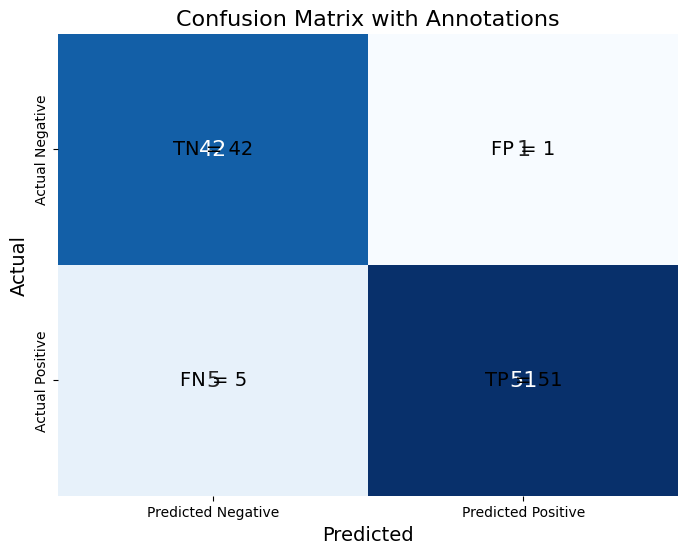

In [31]:
# Predict on the test set
test_pred_rf = rf.predict(X_test)
test_proba_rf = rf.predict_proba(X_test)[:, 1]

# Generate the confusion matrix
cm = confusion_matrix(y_test, test_pred_rf)

# Annotate the confusion matrix with TP, FP, TN, FN
cm_labels = [
    ['TN', 'FP'],
    ['FN', 'TP']
]

# Create a DataFrame for easy labeling
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", cbar=False, annot_kws={"size": 16})

# Add annotations for TP, FP, TN, FN
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_labels[i][j]} = {cm[i][j]}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='black', fontsize=14)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix with Annotations', fontsize=16)
plt.show()